In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from pprint import pprint

In [30]:
# Importar dados do conjunto de treinamento
features = pd.read_csv("conjunto_de_treinamento.csv")

# Remover colunas
features = features.drop(
    [
         "id_solicitante",
         "grau_instrucao",
         "estado_onde_nasceu",
         "estado_onde_reside",
         "codigo_area_telefone_residencial",
         "estado_onde_trabalha",
         "codigo_area_telefone_trabalho",
         "local_onde_reside",
         "local_onde_trabalha"
    ],
    axis=1
)

# Correção da coluna "sexo"
features.loc[features["sexo"] == " ", "sexo"] = "N"

# Divisão dos dados categóricos
features = pd.get_dummies(features,columns=
    [
         "produto_solicitado",
         "sexo",
         "estado_civil",
         "nacionalidade",
         "tipo_residencia",
         "dia_vencimento",
         "profissao",
         "forma_envio_solicitacao",
         "profissao_companheiro",
         "grau_instrucao_companheiro",
         "ocupacao"
    ]
)

# Padronização dos dados binários
binarizer = LabelBinarizer()

binaries = [
    "possui_telefone_trabalho",
    "possui_telefone_residencial",
    "possui_cartao_visa",
    "possui_cartao_mastercard",
    "possui_cartao_diners",
    "possui_cartao_amex",
    "possui_outros_cartoes",
    "possui_carro",
    "vinculo_formal_com_empresa",
    "tipo_endereco",
    "possui_telefone_celular"
]

for v in binaries:
    features[v] = binarizer.fit_transform(features[v])

features = features.interpolate(method="nearest")

# Separação do conjunto em label e features
label = np.array(features["inadimplente"])
features = features.drop("inadimplente", axis=1)

feature_list = list(features.columns)

In [31]:
reg = LassoCV(random_state=12345, cv=10, max_iter=2000, eps=0.000005)
reg.fit(features, label)

LassoCV(alphas=None, copy_X=True, cv=10, eps=5e-06, fit_intercept=True,
        max_iter=2000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=12345,
        selection='cyclic', tol=0.0001, verbose=False)

In [32]:
print("Alpha LassoCV: %f" % reg.alpha_)
print("Score LassoCV: %f" % reg.score(features, label))
coefs = pd.Series(reg.coef_, index = feature_list)
print("Lasso escolheu " + str(sum(coefs != 0)) + " variaveis e excluiu " + str(sum(coefs == 0)) + " variaveis.")

Alpha LassoCV: 0.000135
Score LassoCV: 0.047881
Lasso escolheu 60 variaveis e excluiu 37 variaveis.


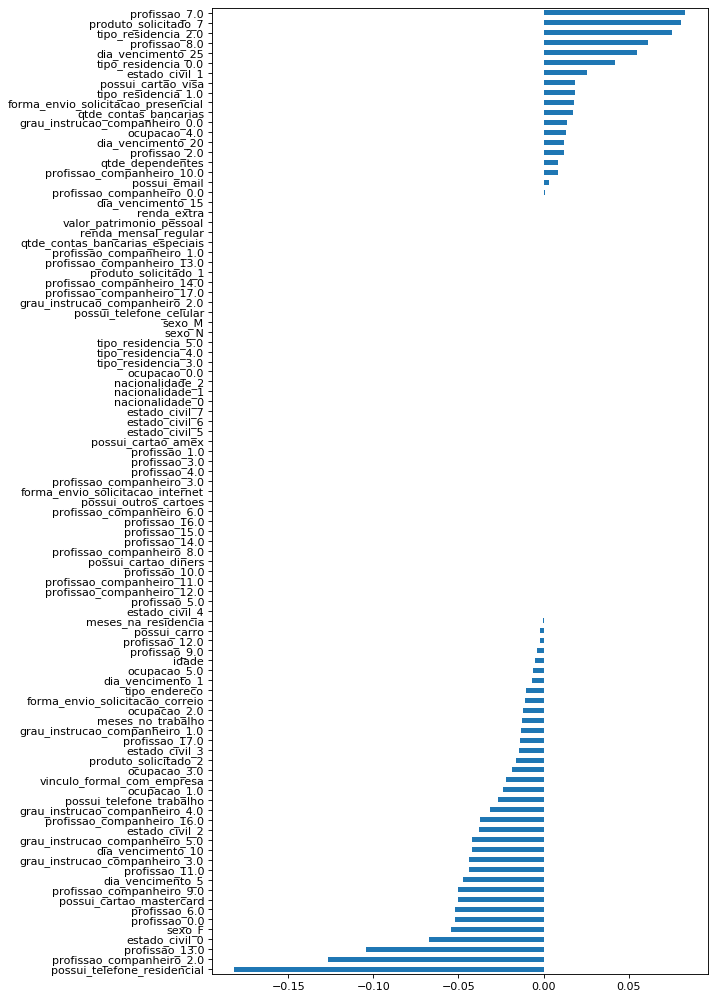

In [33]:
plt.figure(figsize=(8,16), dpi=80)
sorted_coefs = coefs.sort_values()
sorted_coefs.plot(kind="barh")

In [34]:
coefs.loc[coefs == 0].index

Index(['possui_telefone_celular', 'possui_cartao_diners', 'possui_cartao_amex',
       'possui_outros_cartoes', 'produto_solicitado_1', 'sexo_M', 'sexo_N',
       'estado_civil_4', 'estado_civil_5', 'estado_civil_6', 'estado_civil_7',
       'nacionalidade_0', 'nacionalidade_1', 'nacionalidade_2',
       'tipo_residencia_3.0', 'tipo_residencia_4.0', 'tipo_residencia_5.0',
       'profissao_1.0', 'profissao_3.0', 'profissao_4.0', 'profissao_5.0',
       'profissao_10.0', 'profissao_14.0', 'profissao_15.0', 'profissao_16.0',
       'forma_envio_solicitacao_internet', 'profissao_companheiro_1.0',
       'profissao_companheiro_3.0', 'profissao_companheiro_6.0',
       'profissao_companheiro_8.0', 'profissao_companheiro_11.0',
       'profissao_companheiro_12.0', 'profissao_companheiro_13.0',
       'profissao_companheiro_14.0', 'profissao_companheiro_17.0',
       'grau_instrucao_companheiro_2.0', 'ocupacao_0.0'],
      dtype='object')

In [35]:
# Excluir as colunas com baixa correlação
features = features.drop(coefs.loc[coefs == 0].index, axis=1)

feature_list = list(features.columns)

In [12]:
# Standard Scaler
scaler = StandardScaler().fit(features)
features = scaler.transform(features)

features = np.array(features)

In [13]:
# Separar conjunto em treinamento e teste
train_features, test_features, train_label, test_label = train_test_split(features, label, test_size = 0.3, random_state = 12345)

# Modelo base
rf = RandomForestClassifier(n_estimators = 200, random_state = 12345)

# Treinar o modelo
rf.fit(train_features, train_label)

# Previsões
predictions = rf.predict(test_features)

# Erros
errors = abs(np.around(predictions, decimals=0) - test_label)

# Acurácia
print("Acuracia:", 1 - np.mean(errors))

Acuracia: 0.5781666666666667


In [14]:
# Busca automatizada
n_estimators = [int(x) for x in np.linspace(start=160, stop=180, num=5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(100, 120, num = 3)]
max_depth.append(None)
min_samples_split = [40, 50]
min_samples_leaf = [9]
bootstrap = [True]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [100, 110, 120, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [9],
 'min_samples_split': [40, 50],
 'n_estimators': [160, 165, 170, 175, 180]}


In [15]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=12345, n_jobs = -1)
rf_random.fit(features, label)

C:\Users\Gabriel\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [16]:
# Melhores parâmetros
print("Melhores parametros:")
print(rf_random.best_params_)

Melhores parametros:
{'n_estimators': 175, 'min_samples_split': 50, 'min_samples_leaf': 9, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


In [17]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = 100 * abs(np.around(predictions, decimals=0) - test_labels)
    accuracy = 100 - np.mean(errors)
    print("Erro = {:0.4f}.".format(np.mean(errors)))
    print("Acuracia = {:0.2f}%.".format(accuracy))
    
    return accuracy

In [20]:
base_model = RandomForestClassifier(n_estimators = 165, random_state = 12345)
base_model.fit(train_features, train_label)
base_accuracy = evaluate(base_model, test_features, test_label)

Erro = 42.2500.
Acuracia = 57.75%.


In [21]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_label)

Erro = 29.5000.
Acuracia = 70.50%.


In [22]:
# Grid Search
param_grid = {
    'n_estimators': [165],
    'min_samples_split': [40],
    'min_samples_leaf': [9],
    'max_features': ['sqrt'],
    'max_depth': [320],
    'bootstrap': [True]
}

In [23]:
rf = RandomForestClassifier(random_state=12345)

In [24]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 18, n_jobs = -1, verbose = 2)

In [25]:
grid_search.fit(train_features, train_label)
grid_search.best_params_

Fitting 18 folds for each of 1 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   31.7s finished


{'bootstrap': True,
 'max_depth': 320,
 'max_features': 'sqrt',
 'min_samples_leaf': 9,
 'min_samples_split': 40,
 'n_estimators': 165}

In [26]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_label)

Erro = 40.4333.
Acuracia = 59.57%.


In [36]:
# Conjunto de teste
# Importar dados
test_features = pd.read_csv("conjunto_de_teste.csv")

# Corrigir colunas
test_features.loc[test_features["sexo"] == " ", "sexo"] = "N"
test_features = test_features.interpolate(method="nearest")

# Colunas categóricas
test_features = pd.get_dummies(test_features,columns=
    [
         "produto_solicitado",
         "sexo",
         "estado_civil",
         "nacionalidade",
         "tipo_residencia",
         "dia_vencimento",
         "profissao",
         "forma_envio_solicitacao",
         "profissao_companheiro",
         "grau_instrucao_companheiro",
         "ocupacao"
    ]
)

# Colunas binárias
binarizer = LabelBinarizer()

binaries = [
    "possui_telefone_trabalho",
    "possui_telefone_residencial",
    "possui_cartao_visa",
    "possui_cartao_mastercard",
    "possui_cartao_diners",
    "possui_cartao_amex",
    "possui_outros_cartoes",
    "possui_carro",
    "vinculo_formal_com_empresa",
    "tipo_endereco",
    "possui_telefone_celular"
]

for v in binaries:
    test_features[v] = binarizer.fit_transform(test_features[v])
    
# Excluir colunas
test_features = test_features.drop(test_features.columns.difference(feature_list),axis=1)

# Standard scaler
test_features = scaler.transform(test_features)

test_features = np.array(test_features)

result = best_grid.predict(test_features)
result = np.around(result)
result = result.astype(int)

results = pd.DataFrame()
results['id_solicitante'] = np.linspace(start=20001, stop=25000, num=5000, dtype=int)
results['inadimplente'] = result

results.to_csv("results.csv", index=False, header=True)